Forward modelling code. Contains functions that build the matrices required to convert the sky
alm to noisy timeseries observations.

In [51]:
import healpy as hp
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
import seaborn as sns

import spherical_harmonics as SH
import beam_functions as BF
import coordinates as CO

In [62]:
def f(*a):
    return np.concatenate(a, axis=1)


In [47]:
def create_timestream_drift(data, lat=-26.0, lon=116.0, 
                times=np.linspace(0, 24, 24, endpoint=False)):
    """
    REWRITE TO JUST COMPUTE POINTING MATRIX.
    """
    """
    Create timestream and pointing matrix for a driftscan observation
    at (lat, lon) and for times.

    data should be a healpix map

    Really should separate this in to two functions
    (1) to calculate the pointing matrix and (2) to apply it to get time stream

    """

    nside = healpy.npix2nside(len(data))

    # create a timestream of observations
    pointings = []
    timestream = []
    sightings = np.zeros(len(data), dtype=np.float32)

    #calculate the timestream of data
    ls, bs = CO.zenith_drift_scan(lat,lon,times)
    thetas, phis = CO.latlon2thetaphi(ls, bs)

    #currently just a toy model here for testing
    for i in range(len(phis)):
        phi = phis[i]
        theta = thetas[i]
        indx = healpy.pixelfunc.ang2pix(nside, phi*CO.deg2rad, theta*CO.deg2rad)

        #for each time store the data and the pixel observed
        timestream.append(data[indx])
        pointings.append(indx)

        #make matrix of pointings to match to sky
        sightings[indx] += 1

    pointings = np.array(pointings)   #list of pixel for each time step
    timestream = np.array(timestream)  # temperature of pixels

    # pointing matrix is unity in pixel that is observed at that timestep
    #
    # timestream = pointing_matrix * map + noise
    npix = len(data)
    ntime = len(times)
    pointing_matrix = np.zeros((ntime,npix))
    for i in range(ntime):
        pointing_matrix[i, pointings[i]] = 1

    return pointings, timestream, pointing_matrix, sightings
    

In [8]:
from pygdsm import GlobalSkyModel2016

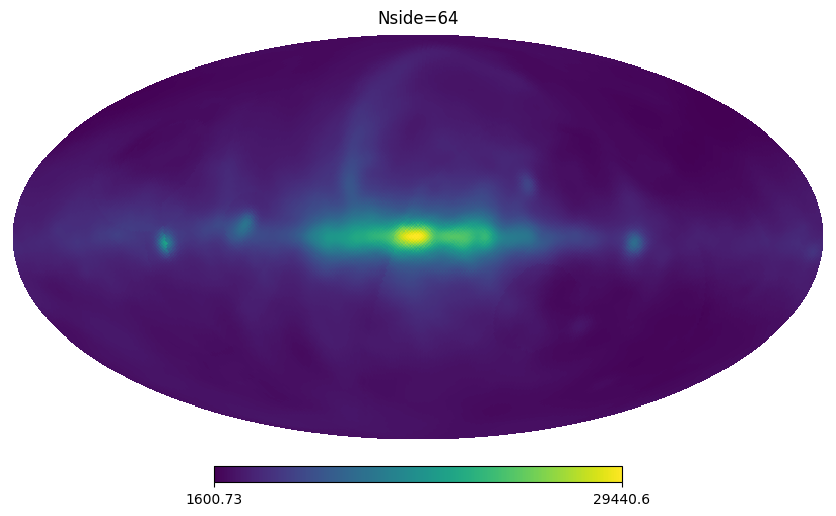

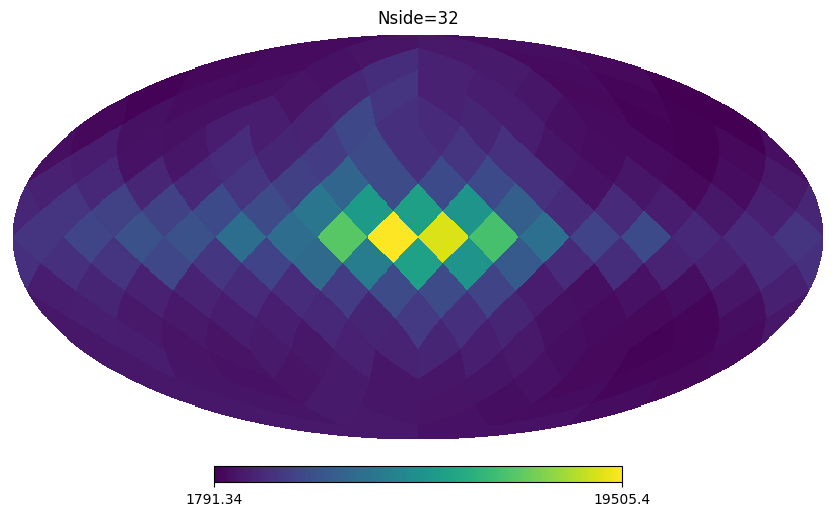

In [38]:
sky = GlobalSkyModel2016(resolution='low')
map = sky.generate(60)
map_lo = hp.pixelfunc.ud_grade(map, nside_out=4)
hp.mollview(map, title="Nside=64")
hp.mollview(map_lo, title="Nside=32")

In [48]:
pointings, timestream, pointing_matrix, sightings = create_timestream_drift(map_lo)

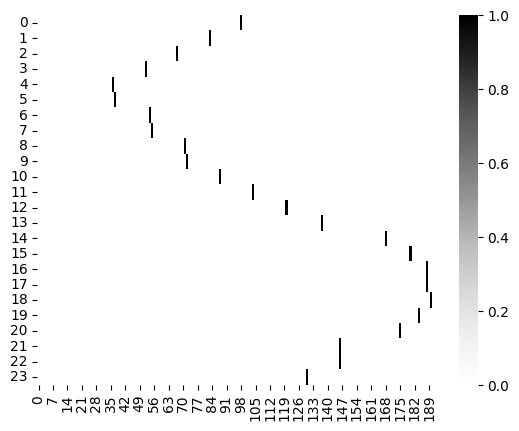

In [46]:
sns.heatmap(pointing_matrix, cmap="Greys")
plt.show()

In [ ]:
def calculate_mapping_matrix(data, Ntau=5, lmax=4, theta0=1.0, nt=24):
    """
    Calculate the mapping matrix A = G.P.Y.B
    to map alm of sky (convolved with beam)
    onto time bins.

    Resultant matrix will be Ntau x Nlm
    """

    nside = healpy.npix2nside(len(data))

    #specify pointing matrix
    times = np.linspace(0,24,nt)[0:-1]
    lat = -26.0  #MWA
    lon = 116.0  #MWA
    pointings, timestream, pointing_matrix, sightings = MM.create_timestream_drift(data, lat, lon, times)

    #specify beam
    beam_use = lambda t: BF.beam_cos(t, theta0=theta0)
    beam_matrix = BF.calc_beam_matrix(nside, lmax, beam_use)

    #spherical harmonic matrix
    Y = CYM.calculate_Y(nside=nside, lmax=lmax)

    #average signal into course time bins
    Nt = pointing_matrix.shape[0]
    G = calculate_averaging_matrix(Ntau, Nt)

    #full mapping matrix
    A_matrix = G @ pointing_matrix @ Y @ beam_matrix

    return A_matrix, G, pointing_matrix, Y, beam_matrix

In [54]:
"""
Code up conversion between spherical coordinate systems to allow
calculation of drift scan sky tracks

I'll use https://aas.aanda.org/articles/aas/pdf/1998/01/ds1449.pdf
as a reference for the conversions
"""

from numpy import cos, sin, arcsin, arccos, arctan2, pi
import numpy as np

deg2rad = pi / 180.0
rad2deg = 180.0 / pi
twopi = 2.0 * pi

def obs_zenith_drift_scan(lat, lon, times=np.linspace(0, 24, 24, endpoint=False)):
    """
    Return the galactic coordinate arrays (l, b) [deg] for
    an zenith-pointing antenna at (lat, lon) [deg] and 
    an array of hour-angle times.
    """
    rubbish = 1.0 #A unimportant for zenith observation
    ha = time * (360.0 / 24.0)   #local sidereal time
    alpha, delta = alt2eqa(rubbish, 0.0, lat, lon+ha)
    l, b = eqa2gal(alpha, delta)
    return l, b

def calc_pointing_matrix(*pointing_coordinates, nside=32):
    """
    Create pointing matrix corresponding to any number of
    sets of pointing coordinates.

    Parameters
    ----------
    pointing_coordinates
        List/array of tuples (l, b) corresponding to each pointing.
        Pass one of these lists for each antenna used.
    nside
        The nside corresponding to the number of pixels of the 
        output matrix.

    Returns
    -------
    P : (sum(N_t for each antenna)) x (Npix) - dimension matrix
        The pointing matrix.
    """
    all_pointing_coordinates = np.concatenate(pointing_coordinates)
    


    
    nside = healpy.npix2nside(len(data))

    # create a timestream of observations
    pointings = []
    timestream = []
    sightings = np.zeros(len(data), dtype=np.float32)

    #calculate the timestream of data
    ls, bs = SC.zenith_drift_scan(lat,lon,times)
    thetas, phis = SC.latlon2thetaphi(ls, bs)

    #currently just a toy model here for testing
    for i in range(len(phis)):
        phi = phis[i]
        theta = thetas[i]
        indx = healpy.pixelfunc.ang2pix(nside, phi*SC.deg2rad, theta*SC.deg2rad)

        #for each time store the data and the pixel observed
        timestream.append(data[indx])
        pointings.append(indx)

        #make matrix of pointings to match to sky
        sightings[indx] += 1

    pointings = np.array(pointings)   #list of pixel for each time step
    timestream = np.array(timestream)  # temperature of pixels

    # pointing matrix is unity in pixel that is observed at that timestep
    #
    # timestream = pointing_matrix * map + noise
    npix = len(data)
    ntime = len(timestream)
    pointing_matrix = np.zeros((ntime,npix))
    for i in range(ntime):
        print(i, pointings[i])
        pointing_matrix[i, pointings[i]] = 1

    return pointings, timestream, pointing_matrix, sightings

def latlon2thetaphi(l, b):
    """
    Convert Galactic latitude and longitude l, b (deg) into spherical
    coordinates theta, phi (deg).
    """

    theta, phi = l, 90 - b  #healpy measures theta differently to latitude
    phi = (phi + 180) % 180
    return theta, phi

def eqa2gal(alpha_deg, delta_deg):
    """
    Convert equatorial coordinates alpha, delta (deg) to
    galactic coordinates l, b (deg).
    """

    alpha = alpha_deg * deg2rad
    delta = delta_deg * deg2rad

    #equinox 2000 coordinates
    d_NGP = 27.12 * deg2rad
    alpha0 = 282.86 * deg2rad
    l0 = 32.93 * deg2rad

    dalpha = alpha - alpha0
    sb = sin(delta) * sin(d_NGP) - cos(delta) * cos(d_NGP) * sin(dalpha)
    b = arcsin(sb)
    cdl = cos(dalpha) * cos(delta) / cos(b)
    sdl =(sin(delta) * cos(d_NGP) + cos(delta) * sin(d_NGP) * sin(dalpha)) / cos(b)

    dl = arctan2(sdl, cdl)
    l = dl + l0
    #l = l % (2.0 * pi) #restrict l to [0,2pi]
    l = (l + twopi) % twopi

    return l * rad2deg, b * rad2deg

def gal2eqa(l_deg, b_deg):
    """
    Convert galactic coordinates l, b (deg) to
    equatorial coordinates alpha, delta (deg).
    """

    l = l_deg * deg2rad
    b = b_deg * deg2rad

    #equinox 2000 coordinates
    d_NGP = 27.12 * deg2rad
    alpha0 = 282.86 * deg2rad
    l0 = 32.93 * deg2rad

    dl = l - l0
    sd = sin(b) * sin(d_NGP) + cos(b) * cos(d_NGP) * sin(dl)
    delta = arcsin(sd)
    cda = cos(dl) * cos(b) / cos(delta)
    sda = (-sin(b) * cos(d_NGP) + cos(b) * sin(d_NGP) * sin(dl)) / cos(delta)

    da = arctan2(sda, cda)
    alpha = da + alpha0
    #alpha = alpha % (2.0 * pi)  #restrict alpha to [0,2pi]
    alpha = (alpha + twopi) % twopi

    return alpha * rad2deg, delta * rad2deg

def _test_gal_eqa():
    """
    Randomly test back and forth works for galactic and equilateral points
    """
    import numpy.random as npr
    tol = 1.0e-4

    value = True
    Ntest = 200
    for i in range(Ntest):
        a = npr.uniform(0.0, 360.0)
        d = npr.uniform(-90.0, 90.0)
        l, b = eqa2gal(a,d)
        a_out, d_out = gal2eqa(l, b)
        value1 = np.abs(a_out - a)<tol
        value2 = np.abs(d_out - d)<tol
        value = np.all([value, value1, value2])
    return value

def eqa2alt(alpha_deg, delta_deg, phi0_deg, theta0_deg):
    """
    Convert equatorial coordinates alpha, delta (deg) to Altazimuth A, z (deg)
    for an observer at latitude phi0 and longitude theta0 (deg).
    """

    alpha = alpha_deg * deg2rad
    delta = delta_deg * deg2rad
    phi0 = phi0_deg * deg2rad
    theta0 = theta0_deg * deg2rad

    ha = theta0 - alpha
    cz = sin(delta) * sin(phi0) + cos(delta) * cos(phi0) * cos(ha)
    z = arccos(cz)
    cA = (-sin(delta) * cos(phi0) + cos(delta) * sin(phi0) * cos(ha)) / sin(z)
    sA = sin(ha) * cos(delta) / sin(z)

    A = arctan2(sA, cA)

    return A * rad2deg, z * rad2deg

def alt2eqa(A_deg, z_deg, phi0_deg, theta0_deg):
    """
    Convert Altazimuth A, z (deg) to equatorial coordinates alpha, delta (deg).
    for an observer at latitude phi0 and longitude theta0 (deg).
    """
    A = A_deg * deg2rad
    z = z_deg * deg2rad
    phi0 = phi0_deg * deg2rad
    theta0 = theta0_deg * deg2rad

    sd = cos(z) * sin(phi0) - sin(z) * cos(phi0) * cos(A)
    delta = arcsin(sd)
    cha = (cos(z) * cos(phi0) + sin(z) * sin(phi0) * cos(A)) / cos(delta)
    sha = sin(A) * sin(z) / cos(delta)
    ha = arctan2(sha, cha)
    ha = (ha + twopi) % twopi #map from [-pi,pi] to [0,2pi]
    alpha = theta0 - ha
    alpha = (alpha + twopi) % twopi

    #alpha = alpha % (2.0 * pi)  #restrict alpha to [0,2pi]


    return alpha * rad2deg, delta * rad2deg

def _test_alt_eqa(phi0=-10.0, theta0 = 24.0):
    """
    Randomly test back and forth works for galactic and equilateral points
    """
    import numpy.random as npr
    tol = 1.0e-4

    value = True
    Ntest = 100
    for i in range(Ntest):
        a = npr.uniform(0.0, 360.0)
        d = npr.uniform(-90.0, 90.0)
        #print("in", a, d)
        A, z = eqa2alt(a,d, phi0, theta0)
        a_out, d_out = alt2eqa(A, z, phi0, theta0)
        #print("out", a_out, d_out)
        value1 = np.abs(a_out - a)<tol
        value2 = np.abs(d_out - d)<tol
        value = np.all([value, value1, value2])
    return value


In [63]:
def obs_zenith_drift_scan(lat, lon, times=np.linspace(0, 24, 24, endpoint=False)):
    """
    Return the galactic coordinate arrays (l, b) [deg] for
    an zenith-pointing antenna at (lat, lon) [deg] and 
    an array of hour-angle times.
    """
    rubbish = 1.0 #A unimportant for zenith observation
    ha = times * (360.0 / 24.0)   #local sidereal time
    alpha, delta = alt2eqa(rubbish, 0.0, lat, lon+ha)
    l, b = eqa2gal(alpha, delta)
    return l, b

np.shape(f(obs_zenith_drift_scan(0,0), obs_zenith_drift_scan(0,0)))

(2, 48)